# 3D Gait Recognition Based on a CNN-LSTM Network with the Fusion of SkeGEI and DA Features

## *Yu Liu, Xinghao Jiang, Tanfeng Sun, Ke Xu*

## Abstract¹

Gait recognition is a promising technology in biometrics in videos surveillance application for its characteristics of non-contact and uniqueness. With the popularization of the Kinect sensor, human gait can be recognized based on the 3D skeletal information. For exploiting raw depth data captured by Kinect device on Skeleton Gait Energy Image (SkeGEI) and Relative Distance and Angle (DA) features fusion is proposed. They are fused in backward to complement each other for gait recognition. In order to maintain as much gait information as possivle, a CNN-LSTM network is designed to extract the temporal spatial deep feature information from SkeGEI and DA features. The experiments evaluated on three datasets show that out approach performs superior to most gait recognition approaches with multi-directional and abnormal patterns.

## Description

This notebook implements the paper published by Liu et al. (2019), [*3D Gait Recognition Based on a CNN-LSTM Network with the Fusion of SkeGEI and DA Features*](https://ieeexplore.ieee.org/abstract/document/8909881). We tried to maintain the maintain the highest fidelity following the paper description to reproduce the results reported for [*Kinect Gait Biometry Dataset*](https://github.com/Vortander/KinectGait/tree/master/Data) and [*CIL Gait Dataset*](https://sites.google.com/site/seokeonchoi/gait-recognition) for research purposes. Unfortunatelly, we couldn't reproduce [*SDU Gait Dataset*](https://sites.google.com/site/sdugait/download) results given the authors didn't responded to our data access request. Also, we'd like to emphasize that we did send our main doubts to the authors via e-mail and we didn't receive any answers.


In [1]:
# All imports come here
import os

import cv2
import numpy as np
import torch
import torch.nn.functional as F

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.io import loadmat
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import find_peaks
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor

%matplotlib inline

##  Feature Modeling

According to the authors, to obtain spatial information and temporal information, two features are proposed in the paper as the following:

$$F = \{F_{SkeGEI}, F_{DA}\}$$

which are input into the network as two-channel. The skeleton spatial information and part of the temporal information would be extracted by SkeGEI, and DA feature woulf provide the rest of temporal information.

### Extraction of Skeletal Gait Energy Image (SkeGEI)

Yu et al. (2019) propose a new gait recognition feature called *SkeGEI* (Skeleton Gait Energy Image), which works similarly to the *GEI* (Gait Energy Image) feature but instead of using raw RGB image to produce the energy images, the authors use the skeletons in three distinct view planes: XY plane, XZ plane and YZ plane as shown in the Figure below:

<img src="skegei.png">

#### 0) Data Loading

Before we follow the steps described in the paper, we need to provide functions to load the data from each dataset. For *Kinect Gait Biometry Dataset* we'll only need to read a *.txt* document for each of the sequences provided for each of the identities presented. On the other hand, *CIL Gait Dataset* is a little bit more complicated. The original data format is a *.mat* file. We used [*Matlab*](https://www.mathworks.com/products/matlab.html) to analyse what the file contains before parsing it using *SciPy* as demonstraded by the following cells.

In [2]:
# Change these to datasets path in your machine
KINECT_GAIT_ROOT = 'h:\\data\\kinectgait'
CIL_GAIT_FILE = 'h:\\data\\cilgait.mat'

In [3]:
def load_kinectgait_data(root):
    """
    Facility function to load Kinect Gait Biometry Dataset.

    :param root: Kinect Gait Biometry Dataset root folder
    :return tuple with data and labels
    """
    data = []
    labels = []
    
    for root, dirs, files in os.walk(KINECT_GAIT_ROOT):
        identity = []
        if len(dirs) == 0:
            for f in files:
                sequence = []
                with open(os.path.join(root, f)) as input_file:
                    lines = input_file.read().splitlines()
                    for line in lines:
                        sequence.append(list(map(float, line.split(';')[1:])))
                identity.append(np.array(sequence).reshape(-1, 20, 3))
                        
            data.append(np.array(identity))
            labels.append(int(root.split('\\')[-1][-3:]))

    return data, labels

In [4]:
def load_cilgait_data(filename):
    """
    Facility function to load CIL Gait Dataset.

    :param filename: CIL Gait Dataset .mat file
    :return tuple with data and labels
    """
    data = []
    labels = []

    mat_data = loadmat(CIL_GAIT_FILE)['all_data']
    for idx, person in enumerate(mat_data[0][0][0]):
        identity = []
        for sequence in person:
            # Kinect SDK v2 has 25 joints with X, Y and Z coordinates
            identity.append(np.array(sequence).reshape(-1, 25, 3))
        data.append(np.array(identity))
        labels.append(idx)
    
    return data, labels


kinectgait_data, kinectgait_labels = load_kinectgait_data(KINECT_GAIT_ROOT)
cilgait_data, cilgait_labels = load_cilgait_data(CIL_GAIT_FILE)

Let's get a sample from each dataset to test our methods in the following steps.

In [5]:
kinectgait_sample = kinectgait_data[0][0][0]
cilgait_sample = cilgait_data[0][0][0]

#### 1) Get binary skeleton gait image

Now that our datasets are properly loaded, we need to obtain images from each of the three planes described in the paper. *Kinect Gait Biometry Dataset* uses [Kinect SDK v1](https://www.microsoft.com/en-us/download/details.aspx?id=40278) to capture its data, while *CIL Gait Dataset* was captured using [Kinect SDK v2](https://www.microsoft.com/en-us/download/details.aspx?id=44561). However, we can still plot both representations using the same function given we pass a list of *bones* as parameter of this function.


In [6]:
bones_v1 = np.array([[0, 1], [1, 2], [2, 3], [2, 4], [4, 5], [5, 6], [6, 7], [2, 8], [8, 9], [9, 10], [10, 11], [0, 12], [12, 13], [13, 14], [14, 15], [0, 16], [16, 17], [17, 18], [18, 19]])

bones_v2 = np.array([[0, 1], [1, 20], [20, 2], [2, 3], [20, 4], [4, 5], [5, 6], [6, 7], [20, 8], [8, 9], [9, 10], [10, 11], [0, 12], [12, 13], [13, 14], [14, 15], [0, 16], [16, 17], [17, 18], [18, 19], [7, 21], [6, 22], [11, 23], [10, 24]])

It's relevant to emphasize that *Kinect Gait Biometry Dataset* doesn't present joints in the same order as Kinect SDK v1 defaults. Therefore, we will use a facility function to pass data through before we plot the skeletons to set the default joint order.

<style>
table {
  border-collapse: collapse;
  width: 90%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 6px;
}
</style>

<table border="0">
  <tr>
    <td><b style="font-size:20px">Joints</b></td>
    <td><b style="font-size:20px">Kinect Gait Biometry Dataset</b></td>
    <td><b style="font-size:20px">Kinect SDK v1</b></td>
    <td><b style="font-size:20px">Kinect SDK v2</b></td>
  </tr>
  <tr>
    <td>0</td>
    <td>Head</td>
    <td>HipCenter</td>
    <td>HipCenter</td>
  </tr>
  <tr>
    <td>1</td>
    <td>ShoulderCenter</td>
    <td>Spine</td>
    <td>Spine</td>
  </tr>
  <tr>
    <td>2</td>
    <td>ShoulderRight</td>
    <td>ShoulderCenter</td>
    <td>Neck</td>
  </tr>
  <tr>
    <td>3</td>
    <td>ShoulderLeft</td>
    <td>Head</td>
    <td>Head</td>
  </tr>
  <tr>
    <td>4</td>
    <td>ElbowRight</td>
    <td>ShoulderLeft</td>
    <td>ShoulderLeft</td>
  </tr>
  <tr>
    <td>5</td>
    <td>ElbowLeft</td>
    <td>ElbowLeft</td>
    <td>ElbowLeft</td>
  </tr>
  <tr>
    <td>6</td>
    <td>WristRight</td>
    <td>WristLeft</td>
    <td>WristLeft</td>
  </tr>
  <tr>
    <td>7</td>
    <td>WristLeft</td>
    <td>HandLeft</td>
    <td>HandLeft</td>
  </tr>
  <tr>
    <td>8</td>
    <td>HandRight</td>
    <td>ShoulderRight</td>
    <td>ShoulderRight</td>
  </tr>
  <tr>
    <td>9</td>
    <td>HandLeft</td>
    <td>ElbowRight</td>
    <td>ElbowRight</td>
  </tr>
  <tr>
    <td>10</td>
    <td>Spine</td>
    <td>WristRight</td>
    <td>WristRight</td>
  </tr>
  <tr>
    <td>11</td>
    <td>HipCenter</td>
    <td>HandRight</td>
    <td>HandRight</td>
  </tr>
  <tr>
    <td>12</td>
    <td>HipRight</td>
    <td>HipLeft</td>
    <td>HipLeft</td>
  </tr>
  <tr>
    <td>13</td>
    <td>HipLeft</td>
    <td>KneeLeft</td>
    <td>KneeLeft</td>
  </tr>
  <tr>
    <td>14</td>
    <td>KneeRight</td>
    <td>AnkleLeft</td>
    <td>AnkleLeft</td>
  </tr>
  <tr>
    <td>15</td>
    <td>KneeLeft</td>
    <td>FootLeft</td>
    <td>FootLeft</td>
  </tr>
  <tr>
    <td>16</td>
    <td>AnkleRight</td>
    <td>HipRight</td>
    <td>HipRight</td>
  </tr>
  <tr>
    <td>17</td>
    <td>AnkleLeft</td>
    <td>KneeRight</td>
    <td>KneeRight</td>
  </tr>
  <tr>
    <td>18</td>
    <td>FootRight</td>
    <td>AnkleRight</td>
    <td>AnkleRight</td>
  </tr>
  <tr>
    <td>19</td>
    <td>FootLeft</td>
    <td>FootRight</td>
    <td>FootRight</td>
  </tr>
  <tr>
    <td>20</td>
    <td>-</td>
    <td>-</td>
    <td>SpineShoulder</td>
  </tr>
  <tr>
    <td>21</td>
    <td>-</td>
    <td>-</td>
    <td>HandTipLeft</td>
  </tr>
  <tr>
    <td>22</td>
    <td>-</td>
    <td>-</td>
    <td>ThumbLeft</td>
  </tr>
  <tr>
    <td>23</td>
    <td>-</td>
    <td>-</td>
    <td>HandTipRight</td>
  </tr>
  <tr>
    <td>24</td>
    <td>-</td>
    <td>-</td>
    <td>ThumbRight</td>
  </tr>
</table>

However, in the Experimental Section, the authors claim that for a fair comparison they employed 20 joints even on Kinect SDK v2 datasets. Thus, we're defining another bones list for Kinect SDK v2. We simply replace the joint number 2 (ShoulderCenter) in Kinect SDK v1 and replace by its correpondent in Kinect SDK v2, more specifically, the joint number 20.

In [7]:
bones_v2_20 = np.array([[0, 1], [1, 20], [20, 3], [20, 4], [4, 5], [5, 6], [6, 7], [20, 8], [8, 9], [9, 10], [10, 11], [0, 12], [12, 13], [13, 14], [14, 15], [0, 16], [16, 17], [17, 18], [18, 19]])

In [8]:
def reorder_joints(data):
    """
    Converts Kinect Gait Biometry Dataset joints order to Kinect SDK v1.
    """
    sdk_v1_map = [11, 10, 1, 0, 3, 5, 7, 9, 2, 4, 6, 8, 13, 15, 17, 19, 12, 14, 16, 18]

    return data[sdk_v1_map]

In [9]:
def plot_skeleton(data, bones):
    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize=(5, 8))
    # set up the axes for the first plot
    ax = fig.gca(projection='3d')

    data = np.squeeze(data)

    maxx = np.amax(data[:, 0])
    minx = np.amin(data[:, 0])
    maxy = np.amax(data[:, 2])
    miny = np.amin(data[:, 2])
    maxz = np.amax(data[:, 1])
    minz = np.amin(data[:, 1])

    for idx, d in enumerate(data):
        ax.text(d[0], d[2], d[1], idx, rotation=-90)

    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

    ax.set_xlim3d(minx, maxx)
    ax.set_ylim3d(miny, maxy)
    ax.set_zlim3d(minz, maxz)
    ax.view_init(azim=-30)

    for i, j in bones:
        ax.plot([data[i, 0], data[j, 0]],
                [data[i, 2], data[j, 2]],
                [data[i, 1], data[j, 1]],
                color='blue')

    plt.axis([minx - 0.5, maxx + 0.5, miny - 0.5, maxy + 0.5])
    plt.show()

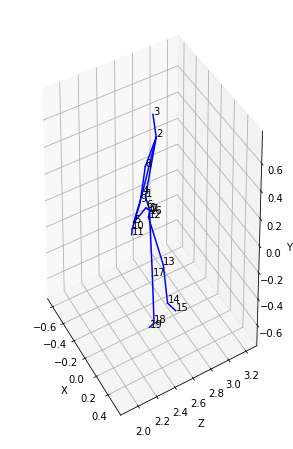

In [10]:
plot_skeleton(reorder_joints(kinectgait_sample), bones_v1)

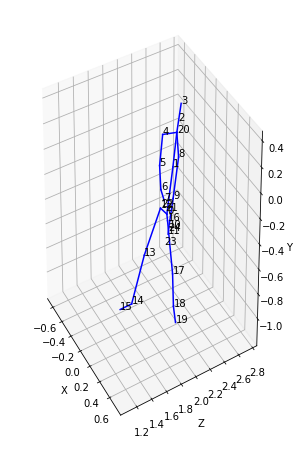

In [11]:
plot_skeleton(cilgait_sample, bones_v2_20)

As we can observe, the bones list used for the plots are well suited for drawing each of the sampled skeletons. Now, we need to obtain a function $B_t(x, y)$ that returns a single frame binary skeleton gait image at time $t$ in a sequence.

The authors instruct in the paper to make sure all skeletons are in the same height range by scaling their coordinates of the head and foot. Also, considering th eneck is most stable joint during a walking, the position of the neck is fixed at a slable point on the image and regarding it as the origin. Then, other joints are converted to relative coordinates. Finally, draw skeleton joints and limbs part on the canvas to get binary skeleton gait image $B_t(x, y)$.

In the paper, the authors do not specify which point should be considered as the stable point on the image. Also, in the architecture scheme we can check that the canvas shape is $88 \times 128 \times 3$

In [31]:
def gen_view(data, bones, verbose=False, axis=(0, 1)):
    """
    Generate a skeleton image using a list of bones and the axis view.
    """
    # We need to use 3 channel img to use OpenCV functions
    canvas = np.zeros((128, 88, 3))

    data = data[:, axis]

    # Normalize data in the range [0, 1] for each axis and scale back to fit image
    # 35 and 100 are magic numbers that we tested untill looks similar to images provided in the paper
    data[:, 0] = (data[:, 0] - data[:, 0].min()) / (data[:, 0].max() - data[:, 0].min()) * 35
    data[:, 1] = (data[:, 1] - data[:, 1].min()) / (data[:, 1].max() - data[:, 1].min()) * 100

    # Fix the neck position for all images
    data[:, 0] += np.abs(data[2, 0] - 45)
    data[:, 1] += np.abs(data[2, 1] - 105)

    # Convert from float to int
    data = data.astype('int8')

    # Draw lines
    for i, j in bones:
        cv2.line(canvas, tuple(data[i]), tuple(data[j]), (255, 255, 255), 1)

    # The image obtained in inverted in the Y axis, thus we need to reverse it
    final_canvas = np.zeros((128, 88, 3))

    for i in range(128):
        final_canvas[i] = canvas[127 - i]

    # Get back to only 1 channel
    final_canvas = final_canvas[:, :, 0]

    # Normalize to [0, 1] pixel range
    final_canvas = (final_canvas - final_canvas.min()) / (final_canvas.max() - final_canvas.min())

    if verbose:
        plt.imshow(final_canvas, cmap='gray')
        plt.axis('off')
        plt.show()

    return final_canvas

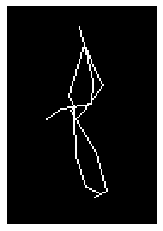

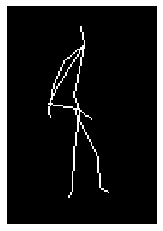

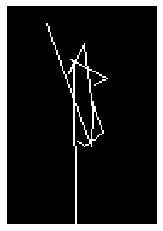

In [13]:
kg_xy_img = gen_view(reorder_joints(kinectgait_sample), bones_v1, verbose=True)
kg_zy_img = gen_view(reorder_joints(kinectgait_sample), bones_v1, verbose=True, axis=(2, 1))
kg_xz_img = gen_view(reorder_joints(kinectgait_sample), bones_v1, verbose=True, axis=(0, 2))

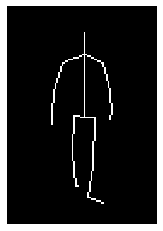

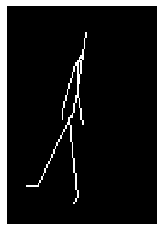

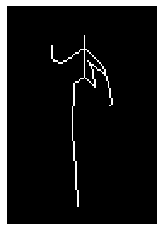

In [14]:
cg_xy_img = gen_view(cilgait_sample, bones_v2_20, verbose=True)
cg_zy_img = gen_view(cilgait_sample, bones_v2_20, verbose=True, axis=(2, 1))
cg_xz_img = gen_view(cilgait_sample, bones_v2_20, verbose=True, axis=(0, 2))

#### 2) Obtain the gait cycle

To obtain good quality SkeGEI images we need to ensure that it contains a complete walking process for human. Thus, using *Euclidean Distance* we're going to compute the walking distance between two feet for each frame in a gait cycle.

$$l_{wd} = \sqrt{(x_r - x_l)^2 + (z_r - z_l)^2}$$

The authors use the frame number differences between every two adjacent off maximum to obtain a gait cycle. Then, they compute the average differences *N* to use in that sequence.

In [28]:
def get_gait_cycles(r_foot, l_foot, smooth_factor=3):
    """"
    Receives a sequence of coordinates for right and left feet
    and return a list of frames where a gait cycle initiates.
    """
    assert r_foot.shape[-1] == 3
    assert l_foot.shape[-1] == 3

    # 1) Compute the Euclidean distance in the vertical view
    dist = np.sqrt((r_foot[:, 0] - l_foot[:, 0]) ** 2 +
                   (r_foot[:, 2] - l_foot[:, 2]) ** 2)

    # 2) Smooth the signal to suppress sensor noise
    smooth_dist = gaussian_filter1d(dist, smooth_factor)

    # 3) Normalize the distances to the interval [0, 1]
    norm_dist = (smooth_dist - smooth_dist.min()) / (smooth_dist.max() - smooth_dist.min())

    # 4) Find distance function peaks
    dist_thr = norm_dist.mean() - norm_dist.std()
    peaks, _ = find_peaks(norm_dist, dist_thr)

    # 5) Return even indexes for a complete gait cycle
    return peaks[::2], norm_dist

In [16]:
kg_seq_sample = kinectgait_data[0][0]
cg_seq_sample = cilgait_data[0][0]

print('Kinect Gait Biometry Dataset sequence shape:', kg_seq_sample.shape)
print('CIL Gait Dataset sequence shape:', cg_seq_sample.shape)

Kinect Gait Biometry Dataset sequence shape: (579, 20, 3)
CIL Gait Dataset sequence shape: (71, 25, 3)


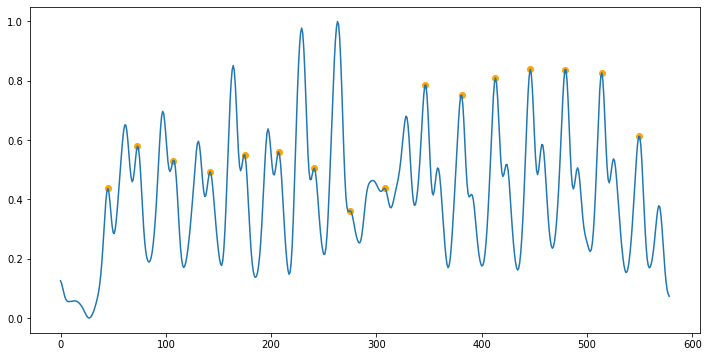

In [17]:
kg_peaks, kg_norm_dist = get_gait_cycles(kg_seq_sample[:, 19], kg_seq_sample[:, 15])

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(kg_seq_sample)), kg_norm_dist)
plt.scatter(kg_peaks, kg_norm_dist[kg_peaks], c='orange')
plt.show()

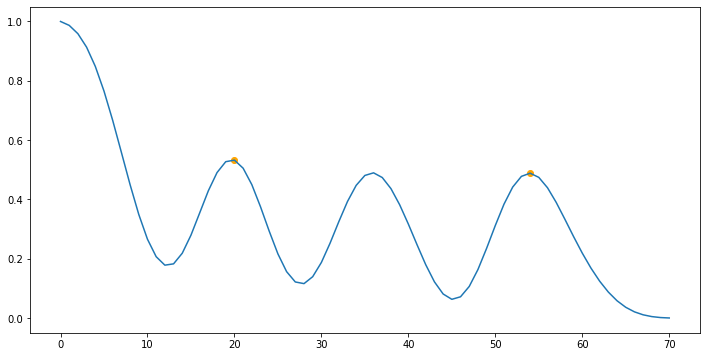

In [18]:
cg_peaks, cg_norm_dist = get_gait_cycles(cg_seq_sample[:, 19], cg_seq_sample[:, 15])

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(cg_seq_sample)), cg_norm_dist)
plt.scatter(cg_peaks, cg_norm_dist[cg_peaks], c='orange')
plt.show()

#### 3) Extracting SkeGEI

To obtain SkeGEI we need to sum over all binary images that compose a gait cycle and divide the resulting image by the number of frames *N* in each gait cycle.

In [19]:
def get_skegei(data, verbose=False):
    skegei = np.zeros((128, 88))
    for img in data:
        skegei += img

    skegei /= len(data)

    if verbose:
        plt.imshow(skegei, cmap='gray')
        plt.axis('off')
        plt.show()

    return skegei

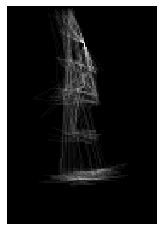

In [20]:
kg_imgs = [gen_view(sample, bones_v1) for sample in kg_seq_sample[kg_peaks[0]: kg_peaks[1]]]
kg_skegei = get_skegei(kg_imgs, verbose=True)

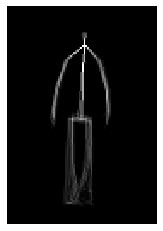

In [21]:
cg_imgs = [gen_view(sample, bones_v1) for sample in cg_seq_sample[cg_peaks[0]: cg_peaks[1]]]
cg_skegei = get_skegei(cg_imgs, verbose=True)

### Relative Distance and Angle(*DA*)

In order to capture some lost information using SkeGEI like speed and frequency, the author propose to extract additional dynamic features to complement the recognition process. To compute such a feature, the authors use distance features (*D*) and angle features (*A*) when people are walking in a scene as illustrated by the image below:

<img src="da-features.png">

where **(a)** represents the distance features and **(b)** represents the angle features.

#### 1) Distance features

This feature computes the relative distance between elbows, wrists, knees, ankes and feet using *Euclidean Distance*.

In [22]:
def dist(right_joint, left_joint):
    return np.sqrt(np.sum((right_joint - left_joint) ** 2))


def get_distance_feats(sample):
    return [
        dist(sample[9], sample[5]),
        dist(sample[10], sample[6]),
        dist(sample[17], sample[13]),
        dist(sample[18], sample[14]),
        dist(sample[19], sample[15]),
    ]

#### 2) Angle features

This feature computes the variety of the rotation angle between the limb joints. According to the image used by the authors, these limbs are: shoulders, elbows, hips, knees and ankles.

In [23]:
def angle(joint_a, joint_b):
    return np.arctan((joint_a[0] - joint_b[0])/(joint_a[1] - joint_b[1]))

def get_angle_dist(sample):
    return [
        angle(sample[4], sample[5]),
        angle(sample[8], sample[9]),
        angle(sample[5], sample[6]),
        angle(sample[9], sample[10]),
        angle(sample[12], sample[13]),
        angle(sample[16], sample[17]),
        angle(sample[13], sample[14]),
        angle(sample[17], sample[18]),
        angle(sample[14], sample[15]),
        angle(sample[18], sample[19]),
    ]

### Setting everything together

Finally, we need to create a *PyTorch Dataset* class for each of the datasets used in the paper to be able to use *PyTorch DataLoader* facilities throughout our training procedure.

In [24]:
def reshape_by_gait_cycles(data, labels, r_foot, l_foot):
    "Create a new dataset using only information from complete gait cycles."
    reshaped_data = []
    reshaped_labels = []

    for person, label in zip(data, labels):
        for seq in person:
            gc_idxs, _ = get_gait_cycles(seq[:, r_foot, :], seq[:, l_foot, :])
            for idx in range(len(gc_idxs) - 1):
                reshaped_data.append(seq[gc_idxs[idx]: gc_idxs[idx+1]])
                reshaped_labels.append(label)

    return reshaped_data, reshaped_labels

In [25]:
class KinectGaitBiometryDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        self.data = []
        self.labels = []

        self.bones = np.array([
            [0, 1],
            [1, 2],
            [2, 3],
            [2, 4],
            [4, 5],
            [5, 6],
            [6, 7],
            [2, 8],
            [8, 9],
            [9, 10],
            [10, 11],
            [0, 12],
            [12, 13],
            [13, 14],
            [14, 15],
            [0, 16],
            [16, 17],
            [17, 18],
            [18, 19]
        ])

        for root, dirs, files in os.walk(self.root):
            identity = []
            if len(dirs) == 0:
                for f in files:
                    sequence = []
                    with open(os.path.join(root, f)) as input_file:
                        lines = input_file.read().splitlines()
                        for line in lines:
                            sequence.append(list(map(float, line.split(';')[1:])))
                    identity.append(np.array(sequence).reshape(-1, 20, 3))
                            
                self.data.append(np.array(identity))
                self.labels.append(int(root.split('\\')[-1][-3:]))

        self.data, self.labels = reshape_by_gait_cycles(self.data, self.labels, 15, 19)
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        

        data = self.data[idx]
        target = self.labels[idx]

        sample = []
        for seq in data:
            skegei = get_skegei([gen_view(s, self.bones) for s in seq])
            da_features = [torch.cat(get_distance_feats(s), get_angle_dist(s)) for s in seq]
            sample.append((skegei, da_features))

        if self.transform:
            sample = self.transform(sample)

        if self.target_transform:
            target = self.target_transform(target)

        return (sample.squeeze(), target)


class CILGaitDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        self.data = []
        self.labels = []

        # The authors claim that for fairness they evaluate all datasets using only 20 joints
        self.bones = np.array([
            [0, 1],
            [1, 20],
            [20, 3],
            [20, 4],
            [4, 5],
            [5, 6],
            [6, 7],
            [20, 8],
            [8, 9],
            [9, 10],
            [10, 11],
            [0, 12],
            [12, 13],
            [13, 14],
            [14, 15],
            [0, 16],
            [16, 17],
            [17, 18],
            [18, 19]
        ])

        mat_data = loadmat(self.root)['all_data']
        for idx, person in enumerate(mat_data[0][0][0]):
            identity = []
            for sequence in person:
                # Kinect SDK v2 has 25 joints with X, Y and Z coordinates
                identity.append(np.array(sequence).reshape(-1, 25, 3))
            self.data.append(np.array(identity))
            self.labels.append(idx)

        self.data, self.labels = reshape_by_gait_cycles(self.data, self.labels, 15, 19)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        

        data = self.data[idx]
        target = self.labels[idx]

        skegei = np.stack([
            get_skegei([gen_view(s, self.bones) for s in data]),
            get_skegei([gen_view(s, self.bones) for s in data], axis=(2, 1)),
            get_skegei([gen_view(s, self.bones) for s in data], axis=(0, 2))
        ], axis=2)

        f_distance = np.array([get_distance_feats(s) for s in data])
        f_angles = np.array([get_angle_dist(s) for s in data])

        da_features = torch.Tensor(np.concatenate([f_distance, f_angles], axis=1))

        if self.transform:
            skegei = self.transform(skegei)

        sample = (skegei, da_features)

        if self.target_transform:
            target = self.target_transform(target)

        return (sample, target)

In [26]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 7, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.conv3 = nn.Conv2d(64, 96, 3, 1)
        self.pool3 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        return x


class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(15, 512, 1)
        self.lstm2 = nn.LSTM(512, 512, 1)

    def forward(self, x):
        x = F.relu(self.lstm1(x))
        x = F.relu(self.lstm2(x))

        return x


class FeatureExtractionModel(nn.Module):
    def __init__(self):
        super(FeatureExtractionModel, self).__init__()

        self.cnn = CNNModel()
        self.lstm = LSTMModel()

        self.fc1 = nn.Linear(96 * 8 * 13, 1024)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(2048, 1024)

    def forward(self, skegei, da):
        fc1 = self.cnn(skegei)
        fc2 = self.lstm(da)
        
        fc1 = F.relu(self.fc1(fc1))
        fc2 = F.relu(self.fc2(fc2))
        feat = F.relu(self.fc3(torch.cat(fc1, fc2)))

        return feat

In [27]:
kinectgait_dataset = KinectGaitBiometryDataset(KINECT_GAIT_ROOT, transform=Compose([ToTensor()]))

In [29]:
cilgait_dataset = CILGaitDataset(CIL_GAIT_FILE, transform=Compose([ToTensor()]))

In [30]:
cilgait_loader = DataLoader(cilgait_dataset, batch_size=32, num_workers=4, pin_memory=True, drop_last=True)

(skegei, da_features), targets = iter(cilgait_loader).next()

print(samples.size())
preds = kinectgait_model(skegei, da_features)
print(preds.size())

BrokenPipeError: [Errno 32] Broken pipe